## HT5 - Proyecto 2 Entrega 3 – Naive Bayes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regresion
from sklearn.model_selection import train_test_split
#Importar Datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
house_prices=pd.read_csv("train.csv")

### Modelo de Regresion (Naive Bayes)

In [2]:
X = regresion.drop_many_nulls(house_prices).dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1100 non-null   int64  
 1   MSZoning       1100 non-null   object 
 2   LotFrontage    1100 non-null   float64
 3   LotArea        1100 non-null   int64  
 4   Street         1100 non-null   object 
 5   LotShape       1100 non-null   object 
 6   LandContour    1100 non-null   object 
 7   Utilities      1100 non-null   object 
 8   LotConfig      1100 non-null   object 
 9   LandSlope      1100 non-null   object 
 10  Neighborhood   1100 non-null   object 
 11  Condition1     1100 non-null   object 
 12  Condition2     1100 non-null   object 
 13  BldgType       1100 non-null   object 
 14  HouseStyle     1100 non-null   object 
 15  OverallQual    1100 non-null   int64  
 16  OverallCond    1100 non-null   int64  
 17  YearBuilt      1100 non-null   int64  
 18  YearRemodAdd 

### Que tan ingenuo?

Estadístico de prueba (ks_statistic) = 0.13188008006363771685
p-value = 0.00000000000000003835
Se rechaza la hipótesis nula: los datos de 'Precio de Venta' NO provienen de una distribución normal.



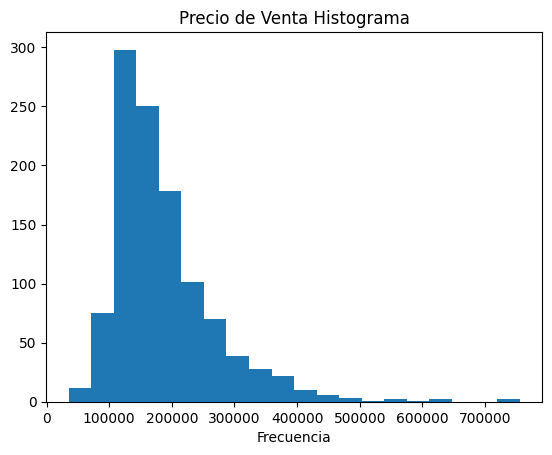

In [3]:
plt.title("Precio de Venta Histograma")
plt.hist(X['SalePrice'], bins=20)
plt.xlabel("Precio de venta ($)")
plt.xlabel("Frecuencia")
regresion.prueba_de_normalidad(X['SalePrice'], "Precio de Venta")

Estadístico de prueba (ks_statistic) = 0.05175132756586431348
p-value = 0.00532289045845288009
Se rechaza la hipótesis nula: los datos de 'Log Precio de Venta' NO provienen de una distribución normal.



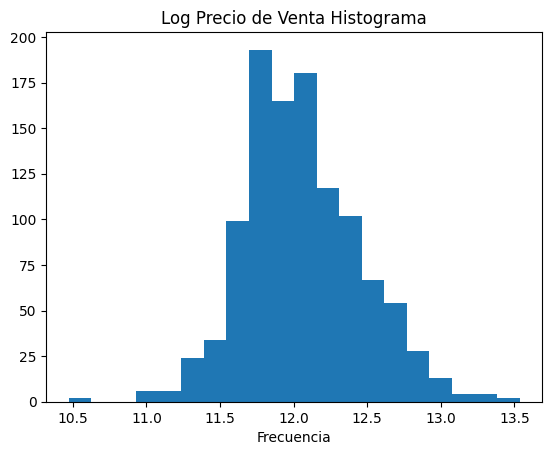

In [4]:
plt.title("Log Precio de Venta Histograma")
plt.hist(np.log1p(X['SalePrice']), bins=20)
plt.xlabel("Log Precio de venta ($)")
plt.xlabel("Frecuencia")
regresion.prueba_de_normalidad(np.log1p(X['SalePrice']), "Log Precio de Venta")

### Test/Train

In [5]:
y = X.pop("SalePrice")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(770, 57)
(330, 57)
(770,)
(330,)


### Cat y Num processing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

cat_pp = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
num_pp = StandardScaler()
pp = ColumnTransformer([
    ('one-hot-encoder', cat_pp,categorical_columns),
    ('standard-scaler', num_pp,numerical_columns)
    ])

### Preprocessing

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
pipeline = Pipeline(
    [('preprocessor',pp),
     ('regressor',GaussianNB())])

In [9]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

gnb = pipeline.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
rmse = root_mean_squared_error(y_test,y_pred)
print("RMSE: ",rmse)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

RMSE:  77211.88494500445
MAE: 41902.3727
MSE: 5961675176.7606


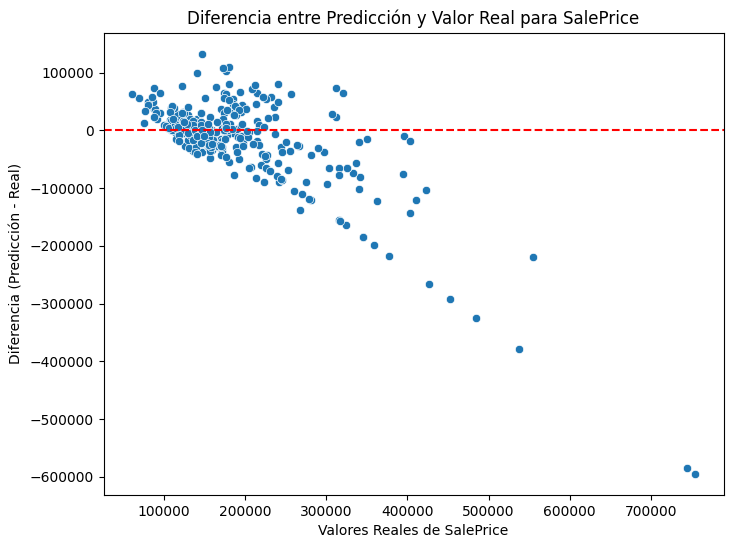

In [10]:
import seaborn as sns
differences = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=differences)
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para ver las diferencias
plt.xlabel('Valores Reales de SalePrice')
plt.ylabel('Diferencia (Predicción - Real)')
plt.title('Diferencia entre Predicción y Valor Real para SalePrice')
plt.show()

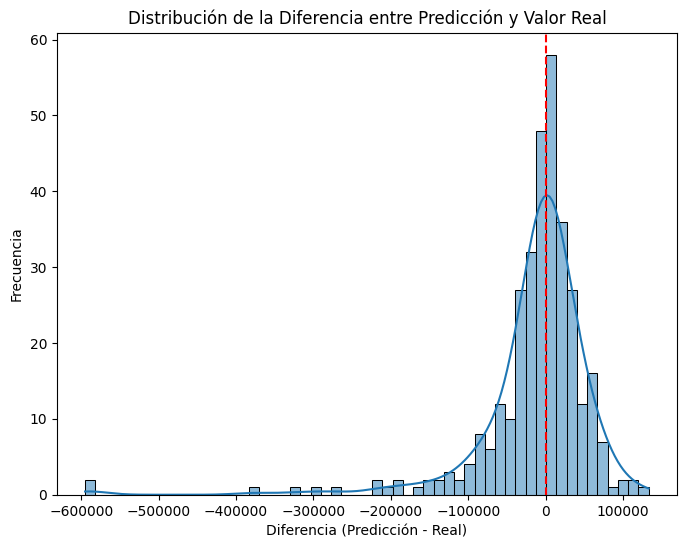

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(differences, kde=True)
plt.axvline(0, color='red', linestyle='--')  # Línea en 0 para ver la tendencia
plt.xlabel('Diferencia (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Diferencia entre Predicción y Valor Real')
plt.show()

In [12]:
from sklearn.preprocessing import KBinsDiscretizer
y_train_log = np.log1p(y_train)  # log(1 + y) avoids log(0) issues
y_test_log = np.log1p(y_test)
num_bins = 100  # Adjust as needed
binner = KBinsDiscretizer(n_bins=num_bins, encode="ordinal", strategy="uniform")  # Equal-width bins

y_train_binned = binner.fit_transform(y_train_log.to_numpy().reshape(-1, 1)).ravel()  # Convert to bin labels
y_test_binned = binner.transform(y_test_log.to_numpy().reshape(-1, 1)).ravel() 

In [13]:
from sklearn.model_selection import GridSearchCV
params =  [{
    "regressor__var_smoothing": np.logspace(0,-9, num=100)
}]
modelo = GridSearchCV(pipeline,param_grid=params,n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")
modelo.fit(X_train,y_train_binned)
modelo.best_params_
print('best score:')
print(modelo.best_score_)
y_pred_binned = modelo.best_estimator_.predict(X_test)

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best score:
-7.374727180619803


In [14]:
y_pred_binned = np.floor(y_pred_binned).astype(int)

y_pred_log = binner.bin_edges_[0][y_pred_binned]  # Map bins back to log space
y_pred = np.expm1(y_pred_log)

In [15]:
y_pred = np.expm1(y_pred_log)
rmse = root_mean_squared_error(y_test,y_pred)
print("RMSE: ",rmse)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

RMSE:  44329.06570368829
MAE: 29071.3142
MSE: 1965066066.1619


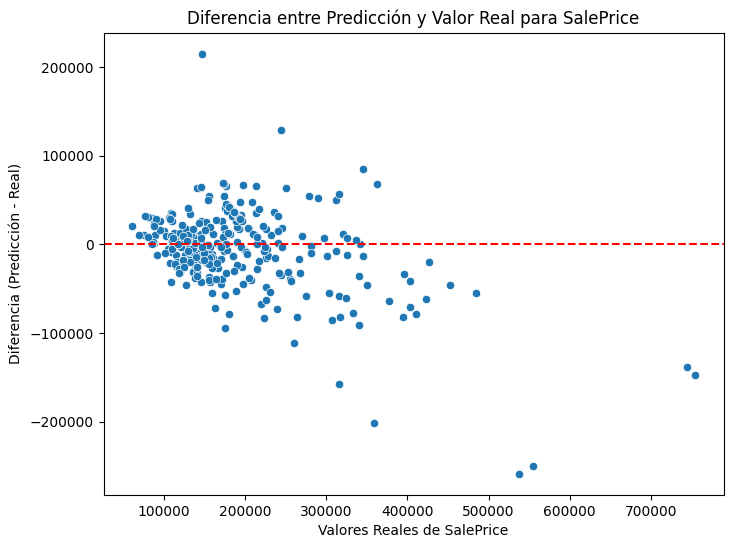

In [16]:
differences = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=differences)
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para ver las diferencias
plt.xlabel('Valores Reales de SalePrice')
plt.ylabel('Diferencia (Predicción - Real)')
plt.title('Diferencia entre Predicción y Valor Real para SalePrice')
plt.show()

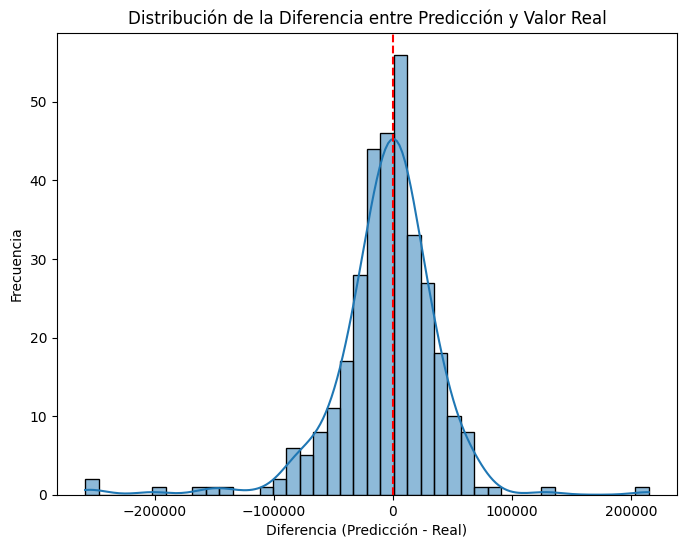

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(differences, kde=True)
plt.axvline(0, color='red', linestyle='--')  # Línea en 0 para ver la tendencia
plt.xlabel('Diferencia (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Diferencia entre Predicción y Valor Real')
plt.show()

## Clasificacion

In [18]:
import classification
data_nbc = classification.sale_price_replace(
    regresion.drop_many_nulls(house_prices)
)
print(data_nbc.dtypes) 

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
ExterQual         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinType2      object
TotalBsmtSF        int64
Heating           object
HeatingQC         object
CentralAir        object
Electrical        object
1stFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
FullBath           int64
HalfBath           int64


c:\Users\diego\OneDrive\Escritorio\2025\Semestre VII\Mineria\Naive_Bayes\classification.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = km.fit_predict(X_pca)


In [19]:
y_nbc = data_nbc.pop('SpThird')

In [20]:

X_nbc = data_nbc
X_trainC, X_testC, y_trainC, y_testC = train_test_split(
    X_nbc, y_nbc, test_size=0.3, train_size=0.7, random_state=42
)
print(X_trainC.shape)
print(X_testC.shape)
print(y_trainC.shape)
print(y_testC.shape)

(1021, 57)
(438, 57)
(1021,)
(438,)


In [21]:
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='most_frequent')  # Fill NaN with most frequent category
num_imputer = SimpleImputer(strategy='mean')

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data_nbc)
categorical_columns = categorical_columns_selector(data_nbc)
cat_pp = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pp_2 = ColumnTransformer([
    ('cat', cat_pp, categorical_columns),
    ('num', num_pp, numerical_columns)
    ])

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
pipeline2 = Pipeline(
    [('preprocessor',pp_2),
     ('regressor',GaussianNB())])

Precisión del modelo: 0.37
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       114
           1       0.93      0.34      0.50       182
           2       0.19      0.86      0.32        35

    accuracy                           0.37       331
   macro avg       0.46      0.49      0.36       331
weighted avg       0.62      0.37      0.40       331



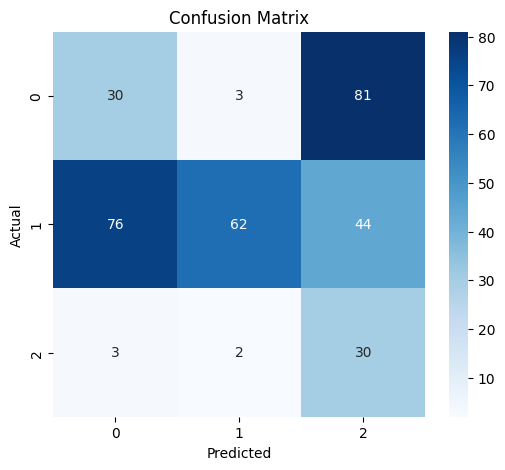

In [24]:
from sklearn.metrics import confusion_matrix
X_trainC = X_trainC.dropna()
y_trainC = y_trainC.loc[X_trainC.index]  # Ensure y_train matches X_train
X_testC = X_testC.dropna()
y_testC = y_testC.loc[X_testC.index] 

cnb = pipeline2.fit(X_trainC, y_trainC)
y_pred = cnb.predict(X_testC)
classification.metrics_and_cm(y_pred, y_testC)

## Modelo de validación cruzada

Precisión del modelo: 0.39
              precision    recall  f1-score   support

           0       0.28      0.30      0.29       284
           1       0.90      0.39      0.55       413
           2       0.18      0.70      0.28        71

    accuracy                           0.39       768
   macro avg       0.45      0.47      0.37       768
weighted avg       0.60      0.39      0.43       768



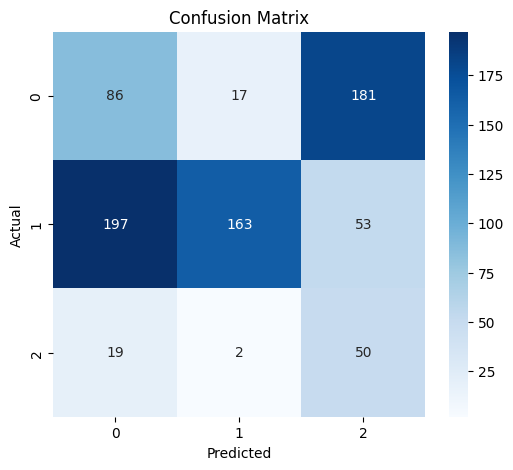

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

y_pred_cv = cross_val_predict(pipeline2, X_trainC, y_trainC, cv=5)

classification.metrics_and_cm(y_pred_cv, y_trainC)

### Pruebas con Diferentes Valores

In [ ]:
params_nb_1 = [{
    "regressor__var_smoothing": np.logspace(0, -9, num=100)
}]

params_nb_2 = [{
    "regressor__var_smoothing": np.logspace(0, -12, num=100)
}]

params_nb_3 = [{
    "regressor__var_smoothing": np.logspace(0, -3, num=100)
}]

In [ ]:
modelo1 = GridSearchCV(pipeline,param_grid=params_nb_1,n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")
modelo2 = GridSearchCV(pipeline,param_grid=params_nb_2,n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")
modelo3 = GridSearchCV(pipeline,param_grid=params_nb_3,n_jobs=2, cv=5,scoring="neg_root_mean_squared_error")

In [33]:
modelo1.fit(X_train,y_train_binned)
modelo1.best_params_
print('best score:')
print(modelo1.best_score_)
y_pred_binned1 = modelo1.best_estimator_.predict(X_test)

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best score:
-7.374727180619803


In [30]:
modelo2.fit(X_train,y_train_binned)
modelo2.best_params_
print('best score:')
print(modelo2.best_score_)
y_pred_binned2 = modelo2.best_estimator_.predict(X_test)

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best score:
-7.478113388602962


In [31]:
modelo3.fit(X_train,y_train_binned)
modelo3.best_params_
print('best score:')
print(modelo3.best_score_)
y_pred_binned3 = modelo3.best_estimator_.predict(X_test)

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best score:
-7.374727180619803


In [40]:
y_pred_binned1 = np.floor(y_pred_binned1).astype(int)

y_pred_log1 = binner.bin_edges_[0][y_pred_binned1]  # Map bins back to log space
y_pred1 = np.expm1(y_pred_log1)
rmse1 = root_mean_squared_error(y_test,y_pred1)
print("RMSE: ",rmse1)
mae1 = mean_absolute_error(y_test, y_pred1)
print(f"MAE: {mae1:.4f}")

mse1 = mean_squared_error(y_test, y_pred1)
print(f"MSE: {mse1:.4f}")

RMSE:  44329.06570368829
MAE: 29071.3142
MSE: 1965066066.1619


In [41]:
y_pred_binned2 = np.floor(y_pred_binned2).astype(int)

y_pred_log2 = binner.bin_edges_[0][y_pred_binned2]  # Map bins back to log space
y_pred2 = np.expm1(y_pred_log2)
rmse2 = root_mean_squared_error(y_test,y_pred2)
print("RMSE: ",rmse2)
mae2 = mean_absolute_error(y_test, y_pred2)
print(f"MAE: {mae2:.4f}")

mse2 = mean_squared_error(y_test, y_pred2)
print(f"MSE: {mse2:.4f}")

RMSE:  44335.743272591455
MAE: 28977.0339
MSE: 1965658131.5331


In [42]:
y_pred_binned3 = np.floor(y_pred_binned3).astype(int)

y_pred_log3 = binner.bin_edges_[0][y_pred_binned3]  # Map bins back to log space
y_pred3 = np.expm1(y_pred_log3)
rmse3 = root_mean_squared_error(y_test,y_pred3)
print("RMSE: ",rmse3)
mae3 = mean_absolute_error(y_test, y_pred3)
print(f"MAE: {mae3:.4f}")

mse3 = mean_squared_error(y_test, y_pred3)
print(f"MSE: {mse3:.4f}")

RMSE:  44329.06570368829
MAE: 29071.3142
MSE: 1965066066.1619
